# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

## Loading Data

In [34]:
import glob

vehicle_images = glob.glob('./dataset/vehicles/**/*.png')
vehicles_count = len(vehicle_images)
print(vehicles_count)
non_vehicle_images = glob.glob('./dataset/non-vehicles/**/*.png')
non_vehicles_count = len(non_vehicle_images)
print(non_vehicles_count)

8792
8968


## Data Visualization

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(nrows, ncols, figsize, images, axis=False, axs_titles=[], title_fontsize=30, height_limit=None, width_limit=None, cmap=None):
    if height_limit != None:
        height = height_limit
    else:
        height = img.shape[0]
        
    if width_limit != None:
        width = width_limit
    else:
        width = img.shape[1]
    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    
    for i, image in enumerate(images):
        if not axis:
            axs[i].axis('off')
        
        if len(axs_titles) > 0:
            axs[i].set_title(axs_titles[i], fontsize=title_fontsize)
        
        axs[i].set_xlim([0,width])
        axs[i].set_ylim([height,0])
        
        axs[i].imshow(image, cmap=cmap)
    return axs

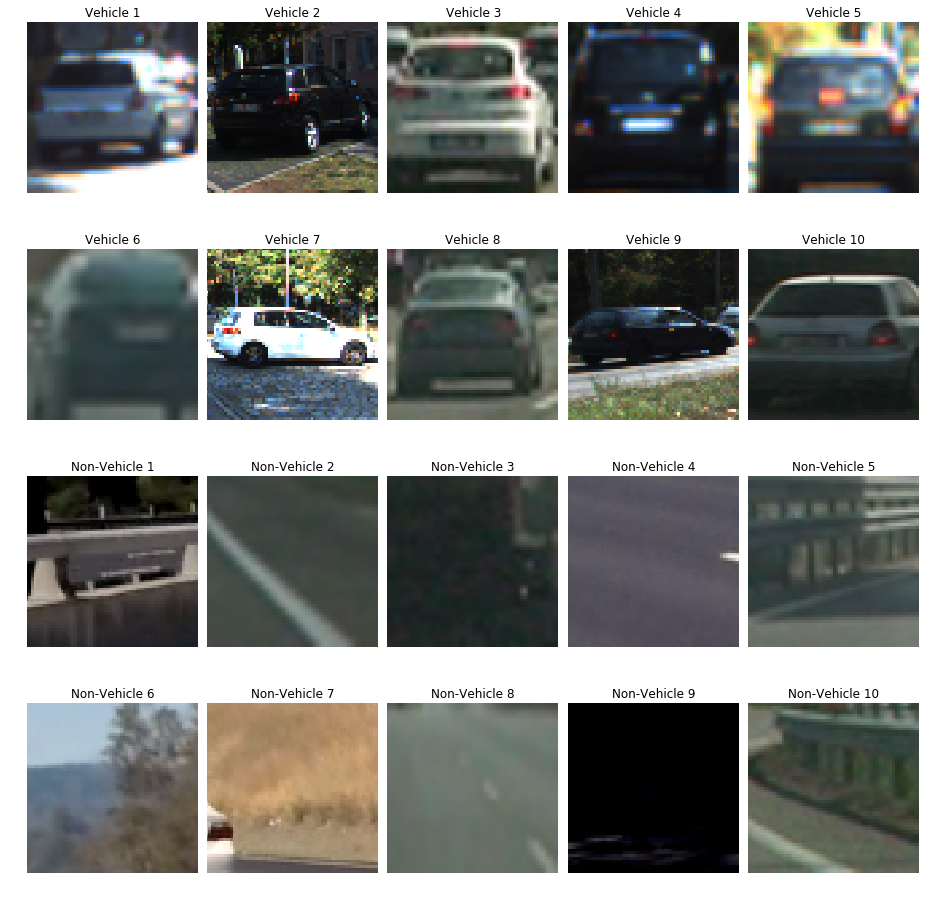

In [36]:
import numpy as np
import cv2

images = []
titles = []

for i in range(10):
    img = cv2.imread(vehicle_images[np.random.randint(0, vehicles_count)])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    images.append(img)
    titles.append('Vehicle ' + str(i+1))

for i in range(10):    
    img = cv2.imread(non_vehicle_images[np.random.randint(0, non_vehicles_count)])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    images.append(img)
    titles.append('Non-Vehicle ' + str(i+1))

axs = plot_images(4, 5, (16, 16), images, axs_titles=titles, title_fontsize=12)

## Image to Histogram of Oriented Gradients Conversion

In [46]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


## HOG Visualization

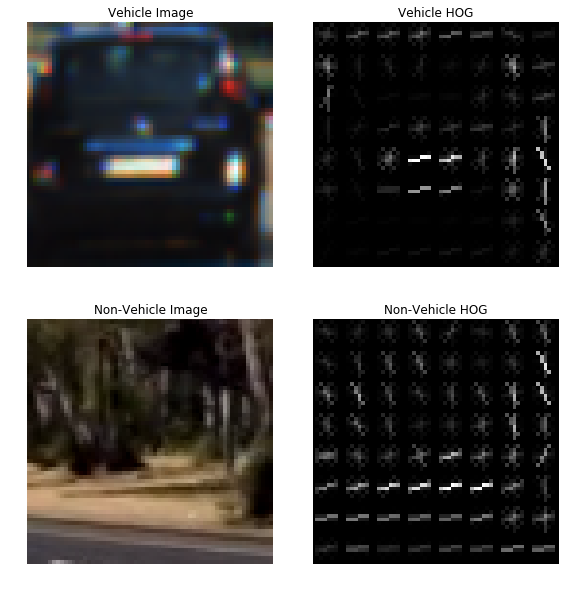

In [47]:
import matplotlib.image as mpimg

vehicle_img = mpimg.imread(vehicle_images[np.random.randint(0, vehicles_count)])
gray_vehicle_img = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2GRAY)
vehicle_features, vehicle_hog = get_hog_features(gray_vehicle_img, 9, 8, 8, vis=True, feature_vec=True)

non_vehicle_img = mpimg.imread(non_vehicle_images[np.random.randint(0, non_vehicles_count)])
gray_non_vehicle_img = cv2.cvtColor(non_vehicle_img, cv2.COLOR_RGB2GRAY)
non_vehicle_features, non_vehicle_hog = get_hog_features(gray_non_vehicle_img, 9, 8, 8, vis=True, feature_vec=True)

images = [vehicle_img, vehicle_hog, non_vehicle_img, non_vehicle_hog]
titles = ['Vehicle Image', 'Vehicle HOG', 'Non-Vehicle Image', 'Non-Vehicle HOG']

axs = plot_images(2, 2, (10, 10), images, axs_titles=titles, title_fontsize=12, cmap='gray')

## Combine Features and Training Classifier

In [48]:
def convert_to_cspace(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: out_img = np.copy(img)
        
    return out_img        

def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_to_cspace(image, cspace=cspace)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [ ]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
vehicle_features = extract_features(vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
non_vehicle_features = extract_features(non_vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print(len(vehicle_features), len(non_vehicle_features))
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

63.38 Seconds to extract HOG features...
8792 8968
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


## Find Vehicle in Image

In [ ]:
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, cspace='RGB'):
    rectangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = convert_to_cspace(img_tosearch, cspace=cspace)  
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1:
                rectangles.append((xleft,ytop)) 
            
    return rectangles, scale, ystart

def draw_rectangles(img, rectangles, scale, ystart):
    window = 64
    
    for rectangle in rectangles:
        xleft = rectangle[0]
        ytop = rectangle[1]
    
        xbox_left = np.int(xleft*scale)
        ytop_draw = np.int(ytop*scale)
        win_draw = np.int(window*scale)
        cv2.rectangle(img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
    
    return img

In [ ]:
test_img = mpimg.imread('./test_images/test5.jpg')

ystart = 400
ystop = 650
scale = 1.5
    
rectangles, scale, ystart = find_cars(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace)

draw_img = np.copy(test_img)
draw_img = draw_rectangles(draw_img, rectangles, scale, ystart)

plt.imshow(draw_img)

## Testing with Different Sliding Window Ranges

In [ ]:
test_img = mpimg.imread('./test_images/test5.jpg')
draw_img = np.copy(test_img)

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2

# (ystart, ystop, scale)
params = [
    (400, 464, 1),
    (432, 496, 1),
    (400, 496, 1.5),
    (448, 544, 1.5),
    (400, 528, 2),
    (464, 592, 2)
]

for param in params:
    ystart = param[0]
    ystop = param[1]
    scale = param[2]
    rectangles, scale, ystart = find_cars(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace)
    draw_img = draw_rectangles(draw_img, rectangles, scale, ystart)
    
plt.imshow(draw_img)